# RandomForestClassifier LabelEncode Target Class
1 column for y
500 estimators first run



### Import Dependencies and Load Data from Database

In [64]:
#Import Dependencies

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [65]:
#SOURCE: https://www.tutorialspoint.com/python_data_access/python_postgresql_database_connection.htm
import psycopg2

#establishing the connection
conn = psycopg2.connect(
   database="Body_Performance", user='postgres', password='passwordhere', host='localhost', port= '5432'
)
#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Executing an MYSQL function using the execute() method
cursor.execute("select version()")

# Fetch a single row using fetchone() method.
data = cursor.fetchone()
print("Connection established to: ",data)



Connection established to:  ('PostgreSQL 12.13, compiled by Visual C++ build 1914, 64-bit',)


In [66]:
body_df = pd.read_sql('select * from body_performance', con=conn)
body_df.head()

,age,gender,height_cm,weight_kg,body_fat_pct,diastolic,systolic,gripforce,sit_and_bend_forward_cm,sit_ups_counts,broad_jump_cm,ranking
0,27,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [67]:
#Closing the connection to the database
conn.close()


### Explore and Analyze Data

In [68]:
# Count of participants by ranking
ranking_count = body_df.value_counts("ranking")
ranking_count

ranking
C    3349
D    3349
A    3348
B    3347
dtype: int64

In [69]:
#is gender signficantly skewed to one or the other and how account for that. F looks to be just over 1 third
gender_count = body_df.value_counts("gender")
gender_count

gender
M    8467
F    4926
dtype: int64

In [70]:
#Breakdown of gender by class.  Need to add in percentage to see if it matters
gender_class = body_df.groupby(["ranking", "gender"])["gender"].count()
print(gender_class)

ranking  gender
A        F         1484
         M         1864
B        F         1185
         M         2162
C        F         1112
         M         2237
D        F         1145
         M         2204
Name: gender, dtype: int64


In [71]:
# Check the value count of ages, turn into dataframe for sorting
# Create Dataframe
age_df = pd.DataFrame(body_df.value_counts("age")).reset_index()

# Create columns & sort by age
age_df.columns = ["age", "counts"]
age_df.sort_values("age", ascending=True)


,age,counts
0,21,964
1,22,789
2,23,668
5,24,617
3,25,644
4,26,629
6,27,546
7,28,527
8,29,407
9,30,374


<AxesSubplot:ylabel='Density'>

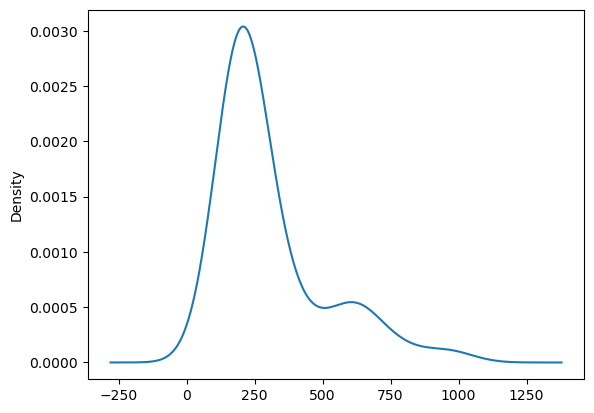

In [72]:
#visualize value count to determine if bucketing is needed

age_df["counts"].plot.density()

### Preprocessing Data for Model 

- Encode string data and target class
- Remove extra columns
- Seperate X and y
- Split training and testing data
- Scale Data

In [73]:
#LabelEncoder on gender column
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

body_df['gender_num'] = labelencoder.fit_transform(body_df['gender'])

body_df.head(10)

,age,gender,height_cm,weight_kg,body_fat_pct,diastolic,systolic,gripforce,sit_and_bend_forward_cm,sit_ups_counts,broad_jump_cm,ranking,gender_num
0,27,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C,1
1,25,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A,1
2,31,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C,1
3,32,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B,1
4,28,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B,1
5,36,F,165.4,55.40,22.0,64.0,119.0,23.8,21.0,27.0,153.0,B,0
6,42,F,164.5,63.70,32.2,72.0,135.0,22.7,0.8,18.0,146.0,D,0
7,33,M,174.9,77.20,36.9,84.0,137.0,45.9,12.3,42.0,234.0,B,1
8,54,M,166.8,67.50,27.6,85.0,165.0,40.4,18.6,34.0,148.0,C,1
9,28,M,185.0,84.60,14.4,81.0,156.0,57.9,12.1,55.0,213.0,B,1


In [74]:
# LabelEncoder on Target values ("ranking") since we have 4 classes but keeping in one column
# See bodyperf_ml_v1.3 for OneHotEncode method on Target

body_df['ranking_num'] = labelencoder.fit_transform(body_df['ranking'])

body_df.head()

,age,gender,height_cm,weight_kg,body_fat_pct,diastolic,systolic,gripforce,sit_and_bend_forward_cm,sit_ups_counts,broad_jump_cm,ranking,gender_num,ranking_num
0,27,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C,1,2
1,25,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A,1,0
2,31,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C,1,2
3,32,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B,1,1
4,28,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B,1,1


In [75]:
#Drop non-encoded original columns

body_df = body_df.drop(["gender", "ranking"], axis=1)

body_df.head(10)

,age,height_cm,weight_kg,body_fat_pct,diastolic,systolic,gripforce,sit_and_bend_forward_cm,sit_ups_counts,broad_jump_cm,gender_num,ranking_num
0,27,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,1,2
1,25,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,1,0
2,31,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,1,2
3,32,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1,1
4,28,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1,1
5,36,165.4,55.40,22.0,64.0,119.0,23.8,21.0,27.0,153.0,0,1
6,42,164.5,63.70,32.2,72.0,135.0,22.7,0.8,18.0,146.0,0,3
7,33,174.9,77.20,36.9,84.0,137.0,45.9,12.3,42.0,234.0,1,1
8,54,166.8,67.50,27.6,85.0,165.0,40.4,18.6,34.0,148.0,1,2
9,28,185.0,84.60,14.4,81.0,156.0,57.9,12.1,55.0,213.0,1,1


In [76]:
# Set X and y values for training

y = body_df["ranking_num"]
X = body_df.drop("ranking_num", axis=1)

print(y.shape)
X.head()

(13393,)


,age,height_cm,weight_kg,body_fat_pct,diastolic,systolic,gripforce,sit_and_bend_forward_cm,sit_ups_counts,broad_jump_cm,gender_num
0,27,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,1
1,25,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,1
2,31,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,1
3,32,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1
4,28,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1


In [77]:
#Confirm y values
y[:10]

0    2
1    0
2    2
3    1
4    1
5    1
6    3
7    1
8    2
9    1
Name: ranking_num, dtype: int32

In [78]:
# Split train/test data and scale using Standard Scaler at this time (mean of 0).  #Test with MinMax(0-1) in other run

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Test using standard 75/25 split. Runs with 70/30 and 80/20 did not improve accuracy or sensitivity.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, train_size=.75)

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirm train/test sizes by printing shape
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(10044, 11)
(3349, 11)


### Run Machine Learning Model - Balanced Random Forest Classifier

### Final Model Choice
- Check feature importances
- Create confusion matrix
- Run classification report
- Plot feature importances


In [114]:
# Run machine learning model using BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import time
start_time = time.time()
# 500 estimators seems best fit
brfc_model = BalancedRandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)

print(f'Training Score: {brfc_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {brfc_model.score(X_test_scaled, y_test)}')

print(f'This model took, {time.time() - start_time} to run')

Training Score: 1.0
Testing Score: 0.7476858763810093
This model took, 12.830825567245483 to run


In [87]:
# Check feature importances for brfc_model

feature_importances = brfc_model.feature_importances_
sorted(zip(brfc_model.feature_importances_, X.columns), reverse=True)

[(0.25721894078292784, 'sit_and_bend_forward_cm'),
 (0.13269569642089907, 'sit_ups_counts'),
 (0.09816502250703052, 'body_fat_pct'),
 (0.08842318402783095, 'weight_kg'),
 (0.08838129440855168, 'age'),
 (0.08194967684001049, 'gripforce'),
 (0.07460430211355464, 'broad_jump_cm'),
 (0.06431713488133241, 'height_cm'),
 (0.05219477142155984, 'systolic'),
 (0.04912491718834628, 'diastolic'),
 (0.01292505940795641, 'gender_num')]

In [88]:
# Print Accuracy score and confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

predictions = brfc_model.predict(X_test_scaled)
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.7476858763810093


In [89]:
# printing confusion matrix     
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1", "Actual 2", "Actual 3"],
    columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3"])
display(cm_df)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,710,98,6,4
Actual 1,181,547,93,24
Actual 2,69,161,552,53
Actual 3,10,50,96,695


In [90]:
#Classification report for brfc

print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       818
           1       0.64      0.65      0.64       845
           2       0.74      0.66      0.70       835
           3       0.90      0.82      0.85       851

    accuracy                           0.75      3349
   macro avg       0.75      0.75      0.75      3349
weighted avg       0.75      0.75      0.75      3349



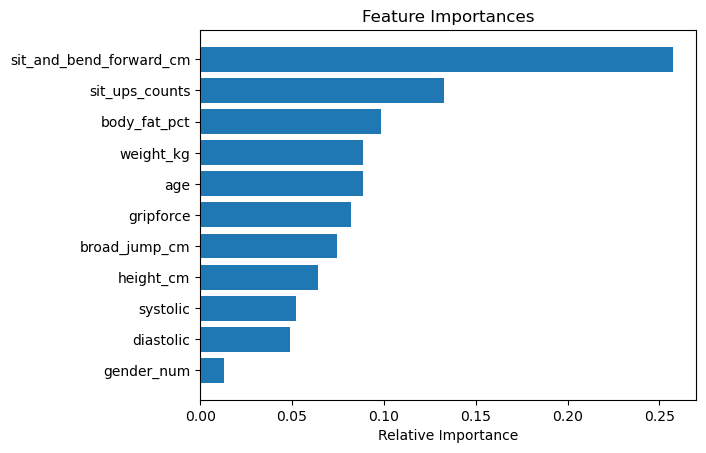

In [91]:
#Plot feature importances to show which has the most impact

#Define and sort
features = X.columns
indices = np.argsort(feature_importances)

#Format chart
plt.title("Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], color="#1f77b4", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [115]:
from sklearn.tree import export_graphviz

estimator = brfc_model.estimators_[10]

print(estimator)

DecisionTreeClassifier(max_features='sqrt', random_state=1800426750)


In [123]:
from sklearn.tree import export_graphviz

estimator = brfc_model.estimators_[0]
target_ranks = ["A", "B", "C", "D"]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features,
                class_names = target_ranks,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

fig.savefig('tree.png')

#### BRFC with n_estimators = 1000


In [92]:
# Run machine learning model using different n_estimators

# 500 estimators seems best fit
brfc_model2 = BalancedRandomForestClassifier(random_state=1, n_estimators=1000).fit(X_train_scaled, y_train)

print(f'Training Score: {brfc_model2.score(X_train_scaled, y_train)}')
print(f'Testing Score: {brfc_model2.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.7438041206330248


In [93]:
predictions2 = brfc_model2.predict(X_test_scaled)
acc_score2 = accuracy_score(y_test, predictions2)
print(f"Accuracy Score : {acc_score2}")

print("Classification Report")
print(classification_report(y_test, predictions2))

Accuracy Score : 0.7438041206330248
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       818
           1       0.64      0.64      0.64       845
           2       0.73      0.65      0.69       835
           3       0.89      0.81      0.85       851

    accuracy                           0.74      3349
   macro avg       0.75      0.74      0.74      3349
weighted avg       0.75      0.74      0.74      3349



In [105]:
# printing confusion matrix     
cm2 = confusion_matrix(y_test, predictions2)
cm_df2 = pd.DataFrame(
    cm2, index=["Actual 0", "Actual 1", "Actual 2", "Actual 3"],
    columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3"])
display(cm_df2)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,708,99,9,2
Actual 1,183,545,91,26
Actual 2,71,164,545,55
Actual 3,10,50,98,693


#### BRFC with n_estimators = 300


In [96]:
# Run machine learning model using different n_estimators

# 500 estimators seems best fit
brfc_model3 = BalancedRandomForestClassifier(random_state=1, n_estimators=300).fit(X_train_scaled, y_train)

print(f'Training Score: {brfc_model3.score(X_train_scaled, y_train)}')
print(f'Testing Score: {brfc_model3.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.7384293819050463


In [97]:
predictions3 = brfc_model3.predict(X_test_scaled)
acc_score3 = accuracy_score(y_test, predictions3)
print(f"Accuracy Score : {acc_score3}")

print("Classification Report")
print(classification_report(y_test, predictions3))

Accuracy Score : 0.7384293819050463
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       818
           1       0.62      0.63      0.63       845
           2       0.73      0.66      0.69       835
           3       0.90      0.82      0.85       851

    accuracy                           0.74      3349
   macro avg       0.74      0.74      0.74      3349
weighted avg       0.74      0.74      0.74      3349



In [104]:
# printing confusion matrix     
cm3 = confusion_matrix(y_test, predictions3)
cm_df3 = pd.DataFrame(
    cm3, index=["Actual 0", "Actual 1", "Actual 2", "Actual 3"],
    columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3"])
display(cm_df3)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,697,110,10,1
Actual 1,186,535,99,25
Actual 2,66,167,547,55
Actual 3,10,51,96,694


### BRFC with MinMax Scaler, 500 estimators

In [99]:
# Split train/test data and scale using MinMax(0-1).

from sklearn.preprocessing import MinMaxScaler

# Test using standard 75/25 split. Runs with 70/30 and 80/20 did not improve accuracy or sensitivity.
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=1, train_size=.75)

scaler = MinMaxScaler().fit(X_train2)

X_train_scaled2 = scaler.transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

# Confirm train/test sizes by printing shape
print(X_train_scaled2.shape)
print(X_test_scaled2.shape)

(10044, 11)
(3349, 11)


In [107]:
# Run machine learning model using BalancedRandomForestClassifier

# 500 estimators seems best fit
brfc_model4 = BalancedRandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled2, y_train2)

print(f'Training Score: {brfc_model4.score(X_train_scaled2, y_train2)}')
print(f'Testing Score: {brfc_model4.score(X_test_scaled2, y_test2)}')

Training Score: 1.0
Testing Score: 0.7473872797850104


In [101]:
# Check feature importances for brfc_model

feature_importances2 = brfc_model4.feature_importances_
sorted(zip(brfc_model4.feature_importances_, X.columns), reverse=True)

[(0.25721894078292784, 'sit_and_bend_forward_cm'),
 (0.13269569642089907, 'sit_ups_counts'),
 (0.09816502250703052, 'body_fat_pct'),
 (0.08842318402783095, 'weight_kg'),
 (0.08838129440855168, 'age'),
 (0.08194967684001049, 'gripforce'),
 (0.07460430211355464, 'broad_jump_cm'),
 (0.06431713488133241, 'height_cm'),
 (0.05219477142155984, 'systolic'),
 (0.04912491718834628, 'diastolic'),
 (0.01292505940795641, 'gender_num')]

In [102]:
predictions4 = brfc_model4.predict(X_test_scaled2)
acc_score4 = accuracy_score(y_test2, predictions4)
print(f"Accuracy Score : {acc_score4}")

print("Classification Report")
print(classification_report(y_test2, predictions4))

Accuracy Score : 0.7473872797850104
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       818
           1       0.64      0.65      0.64       845
           2       0.74      0.66      0.70       835
           3       0.90      0.82      0.85       851

    accuracy                           0.75      3349
   macro avg       0.75      0.75      0.75      3349
weighted avg       0.75      0.75      0.75      3349



In [103]:
# printing confusion matrix     
cm4 = confusion_matrix(y_test2, predictions4)
cm_df4 = pd.DataFrame(
    cm4, index=["Actual 0", "Actual 1", "Actual 2", "Actual 3"],
    columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3"])
display(cm_df4)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,707,100,7,4
Actual 1,182,549,91,23
Actual 2,69,161,552,53
Actual 3,10,49,97,695


### Read in individual tables - Physical and Activity Metrics


In [108]:
#SOURCE: https://www.tutorialspoint.com/python_data_access/python_postgresql_database_connection.htm

#establishing the connection
conn = psycopg2.connect(
   database="Body_Performance", user='postgres', password='passwordhere', host='localhost', port= '5432'
)
#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Executing an MYSQL function using the execute() method
cursor.execute("select version()")

# Fetch a single row using fetchone() method.
data = cursor.fetchone()
print("Connection established to: ",data)


Connection established to:  ('PostgreSQL 12.13, compiled by Visual C++ build 1914, 64-bit',)


In [109]:
physical_df = pd.read_sql('select * from physical_metrics', con=conn)
physical_df.head()

,id_no,age,gender,height_cm,weight_kg,body_fat_pct,diastolic,systolic
0,0,27,M,172.3,75.24,21.3,80.0,130.0
1,1,25,M,165.0,55.80,15.7,77.0,126.0
2,2,31,M,179.6,78.00,20.1,92.0,152.0
3,3,32,M,174.5,71.10,18.4,76.0,147.0
4,4,28,M,173.8,67.70,17.1,70.0,127.0


In [110]:
activity_df = pd.read_sql('select * from activity_metrics', con=conn)
activity_df.head()

,id_no,gripforce,sit_and_bend_forward_cm,sit_ups_counts,broad_jump_cm,ranking
0,0,54.9,18.4,60.0,217.0,C
1,1,36.4,16.3,53.0,229.0,A
2,2,44.8,12.0,49.0,181.0,C
3,3,41.4,15.2,53.0,219.0,B
4,4,43.5,27.1,45.0,217.0,B


In [111]:
#Closing the connection to the database
conn.close()
